In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt
from matplotlib import colors

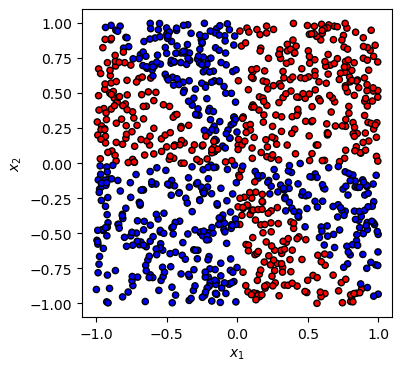

In [2]:
def Data_generate(samples):
    """
    Generates a dataset of points with 1/0 labels.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if x[0]>0 and x[1] >0:
            y = 0
        elif x[0]<0 and x[1] <0:
            y = 1
        elif x[0]> -1*x[1]:
            y = 1
        else:
            y=0
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)

def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(x[:, 0], x[:, 1],  c=y, cmap=colors.ListedColormap(['red','blue']), s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
               
Xdata, ydata = Data_generate(1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()

In [3]:
# Put everything together. 

dev = qml.device("default.qubit", wires=2)

#the observables now have to be opposite under SWAP gate 


@qml.qnode(dev, interface="autograd")
def qcircuit(params, x, y):
    # prepare initial state in a invariant state 
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    for p in params:
        #embedding
        qml.RZ(x[0], wires=0)
        qml.RZ(x[1], wires=1)
        
        #Since exp(X_1+X_2) = RX_1 \cross RX_2
        qml.RX(p[0], wires=0)
        qml.RX(p[0], wires=1)
        
        #Rzz gates
        qml.CNOT([0,1])
        qml.RZ(p[1], wires=1)
        qml.CNOT([0,1])
        
    return qml.expval(qml.Hermitian(y, wires=[0,1]))

def density_matrix(state):
    return state * np.conj(state).T

def cost(params, x, y, state_labels=None):
    # Compute prediction for each input in data batch
    loss = 0.0
    for i in range(len(x)):
        ypred = qcircuit(params, x[i], state_labels[y[i]])
        loss = loss  + (np.array(1) - f) ** 2
    return loss / len(x)

def test(params, x, y, state_labels=None):
    fidelity_values = []
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(state_labels[0]) for dm in state_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [9]:
num_training = 200
num_test = 2000


U1 = np.kron([[0,1],[1,0]], [[0,1],[1,0]])
O0 = density_matrix([[1], [1],[1], [-1]])/4
O1 = U1.dot(O0).dot(U1) 
state_labels = np.array([O0, O1], requires_grad=False)

Xdata, y_train = Data_generate(num_training)
X_train = Xdata
y_train = y_train

Xtest, y_test = Data_generate(num_test)
X_test = Xtest

# # Train using Adam optimizer and evaluate the classifier
num_layers = 10
learning_rate = 0.1
epochs = 20
batch_size = 32



# # initialize random weights
params = np.random.uniform(size=(num_layers, 2), requires_grad=True)


opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)
best_val_accuracy = accuracy_test
best_params = params.copy()

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)
    
    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)
    
    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    
    if accuracy_test > best_val_accuracy:
        best_params = params.copy()
        best_val_accuracy = accuracy_test
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.663285 | Train accuracy: 0.475000 | Test Accuracy: 0.492500
Epoch:  1 | Loss: 0.249744 | Train accuracy: 0.920000 | Test accuracy: 0.935000
Epoch:  2 | Loss: 0.175363 | Train accuracy: 0.845000 | Test accuracy: 0.861000
Epoch:  3 | Loss: 0.130462 | Train accuracy: 0.870000 | Test accuracy: 0.887500
Epoch:  4 | Loss: 0.128625 | Train accuracy: 0.905000 | Test accuracy: 0.912000
Epoch:  5 | Loss: 0.114608 | Train accuracy: 0.870000 | Test accuracy: 0.893500
Epoch:  6 | Loss: 0.107820 | Train accuracy: 0.920000 | Test accuracy: 0.924000
Epoch:  7 | Loss: 0.103548 | Train accuracy: 0.920000 | Test accuracy: 0.924000
Epoch:  8 | Loss: 0.100931 | Train accuracy: 0.915000 | Test accuracy: 0.924500
Epoch:  9 | Loss: 0.098764 | Train accuracy: 0.920000 | Test accuracy: 0.930000
Epoch: 10 | Loss: 0.097113 | Train accuracy: 0.915000 | Test accuracy: 0.928500
Epoch: 11 | Loss: 0.095898 | Train accuracy: 0.935000 | Test accuracy: 0.940000
Epoch: 12 | Loss: 0.095087 | Train accur

In [11]:
# np.save('../data/best_params_discrete_Asymm.npy',best_params)

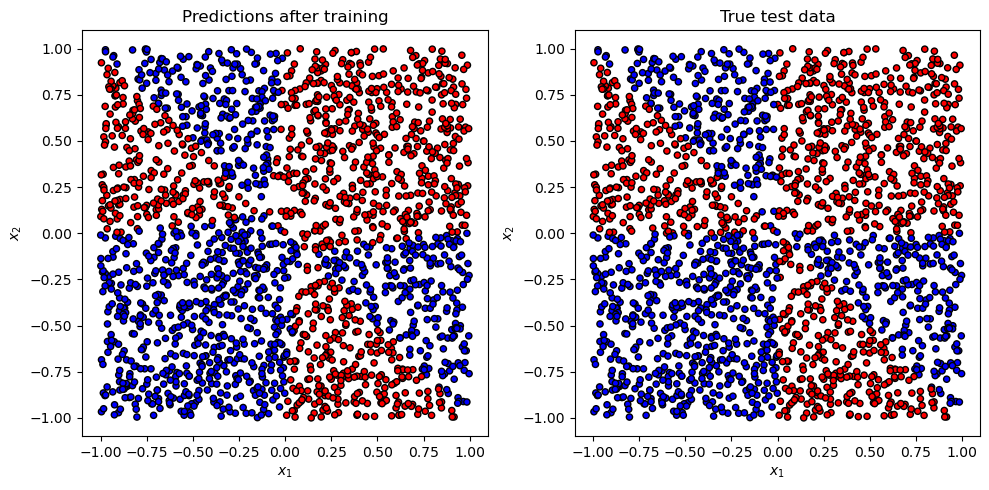

In [10]:
# best_params = np.load('../data/best_params_discrete_Asymm.npy')
Xtest, y_test = Data_generate(num_test)
X_test = Xtest
predicted_test, fidel_test = test(best_params, X_test, y_test, state_labels)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_data(X_test, predicted_test, fig, axes[0])
plot_data(X_test, y_test, fig, axes[1])
axes[0].set_title("Predictions after training")
axes[1].set_title("True test data")
plt.tight_layout()
plt.show()